In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# from degree_days import dds
from tensor_custom_core import *
sys.path.insert(0, '../../aaai18/code/')
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import *
from create_matrix import *
from sklearn.metrics.pairwise import cosine_similarity

import random
from sklearn.cluster import KMeans

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [2]:
df, dfc, tensor, static_feature = create_region_df_dfc_static('Austin', 2014, 1, 13)
L = get_L(static_feature)
case = 2
a = 3
b = 3
weight_matrix = np.ones(tensor.shape)
T_constant = np.ones(12).reshape(-1, 1)
tensor_copy = tensor.copy()
H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L,
                                                          a,
                                                          b, weight_matrix,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [3]:
from sklearn.cluster import KMeans
# for home factors learnt from aggregate readings
X = H.copy()
X = X/np.max(X)
cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
x1, x2 = (-np.var(X, axis=0)).argsort()[:2]

x1=2 
x2=0

34


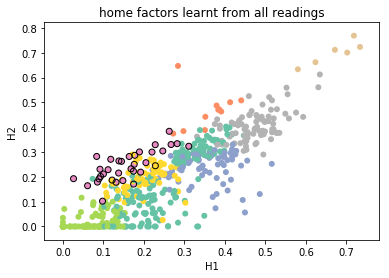

In [4]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(tensor)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:, x1], X[:, x2], c = cluster, cmap='Set2', lw=0)
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")

target_cluster_id = 4
target_cluster_idx = [i for i, j in enumerate(cluster) if j == target_cluster_id]
ax.scatter(X[target_cluster_idx, x1], X[target_cluster_idx, x2], color='black', marker='o', facecolors='none')
print len(target_cluster_idx)

In [5]:
len(target_cluster_idx)

34

In [6]:
import random
random.seed(10)
random.shuffle(target_cluster_idx)
test_idx = target_cluster_idx[:6]
validate_idx = target_cluster_idx[6:12]
test_validate_idx = np.r_[test_idx, validate_idx]
train_idx = list(set(list(range(533))) - set(test_validate_idx))

In [7]:
train_ix = df.index[train_idx]
test_ix = df.index[test_idx]
validate_ix = df.index[validate_idx]
idx = np.r_[test_ix, validate_ix, train_ix]
df_t = df.loc[idx]
tensor = get_tensor(df_t, 1, 13)
L_inner = L[np.ix_(np.r_[test_validate_idx, train_idx], np.r_[test_validate_idx, train_idx])]

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
num_home_factor = 3
num_season_factor = 3

num_test = len(test_ix)
num_validate = len(validate_ix)
num_train = len(train_ix)

num_iterations = 20

train_df = df.loc[train_ix]
test_validate_df = df.loc[np.r_[test_ix, validate_ix]]

train_tensor = get_tensor(train_df, 1, 13)
test_validate_tensor = get_tensor(test_validate_df, 1, 13)

L_train = L[np.ix_(train_idx, train_idx)]
L_test_validate = L[np.ix_(test_validate_idx, test_validate_idx)]


weight_matrices = {}
train_weight = np.ones(train_tensor.shape)

H = {}

choose = "max"

pred = {}
for iterations in range(num_iterations):
    pred[iterations] = {}
    for appliance in APPLIANCES_ORDER:
        pred[iterations][appliance] = []

tv_weight = np.ones(test_validate_tensor.shape)
print tv_weight.shape

for iteration in range(num_iterations):
    print "iteration: ", iteration
    
    weight_matrices[iteration] = train_weight
    tensor_copy = train_tensor.copy()

    # do tensor factorization
    H_train, A_train, T_train, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                               L_train,
                                                              num_home_factor,
                                                              num_season_factor,
                                                             train_weight,
                                                              num_iter=3000,
                                                              lr=0.1, dis=True,
                                                              lam=0,
                                                              T_known=T_constant)

    # use A, T to learn Home factors of validate and test homes
    tensor_copy = test_validate_tensor.copy()
    print tensor_copy.shape
    
    
    H_tv, A_tv, T_tv, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L_test_validate,
                                                                       num_home_factor, num_season_factor, tv_weight,
                                                                       num_iter=3000, lr=0.1, dis=True, lam=0,
                                                                       A_known=A_train, T_known=T_train)
    
    HAT = multiply_case(H_tv, A_tv, T_tv, 2)
    for appliance in APPLIANCES_ORDER:
        pred[iteration][appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index = test_ix))
                
    # use the Home factors to update the weight matrix
    H_validate = H_tv[num_test:]
    
    H_validate_train = np.r_[H_validate, H_train]
    similarities = cosine_similarity(H_validate_train)
    sim = similarities[num_validate:, :num_validate]
    ####
    sim = sim.max(axis=1)
    sim = (sim - sim.min())/(sim.max() - sim.min())
#     sim[200:] = 0
    ####
    print len
    train_weight = np.repeat(sim.reshape(-1, 1), 12*7, axis=1).reshape(-1, 7, 12)
    print train_weight.shape
    
    # store the home factors
    H[iteration] = np.r_[H_tv, H_train]
    

(12, 7, 12)
iteration:  0
496.186979347
137.901043324
97.8573053169
92.3670788774
86.7920163102
82.7346100716
(12, 7, 12)
505.323061908
135.171742959
108.464172387
101.225456105
96.1870508576
92.3135678788
<built-in function len>
(521, 7, 12)
iteration:  1
439.215805524
121.784214066
85.6163086817
80.4355890206
76.0538556919
73.195031259
(12, 7, 12)
502.471739772
121.962511219
99.6097756625
93.9657533929
90.1370064278
87.3217146681
<built-in function len>
(521, 7, 12)
iteration:  2
429.133481392
119.036318381
83.4261602347
78.3203054389
74.1822112363
71.4568618852
(12, 7, 12)
501.761508267
118.694616427
97.0787133276
91.6622896058
88.0948917039
85.5610596144
<built-in function len>
(521, 7, 12)
iteration:  3
435.990358267
121.196722503
84.987437294
79.824315281
75.5024897712
72.638872531
(12, 7, 12)
502.128998783
120.296712777
98.149332445
92.5515274233
88.836344919
86.1726566201
<built-in function len>
(521, 7, 12)
iteration:  4
435.840246812
120.993158855
84.8600505555
79.708236427
7

In [45]:
import pickle
pred = {}
pred_validation = {}
H = {}
A = {}
T = {}
weight_matrices = {}
for choice in ['max', 'min']:
    
    pred[choice] = pickle.load(open("./results/pred_{}.pkl".format(choice)))
    pred_validation[choice] = pickle.load(open("./results/pred_validation_{}.pkl".format(choice)))
    H[choice] = pickle.load(open("./results/H_{}.pkl".format(choice)))
    A[choice] = pickle.load(open("./results/A_{}.pkl".format(choice)))
    T[choice] = pickle.load(open("./results/T_{}.pkl".format(choice)))
    weight_matrices[choice] = pickle.load(open("./results/weight_matrices_{}.pkl".format(choice)))

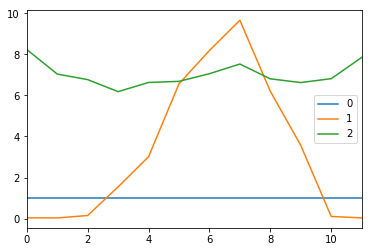

In [40]:
pd.DataFrame(T_train).plot()
plt.title("")

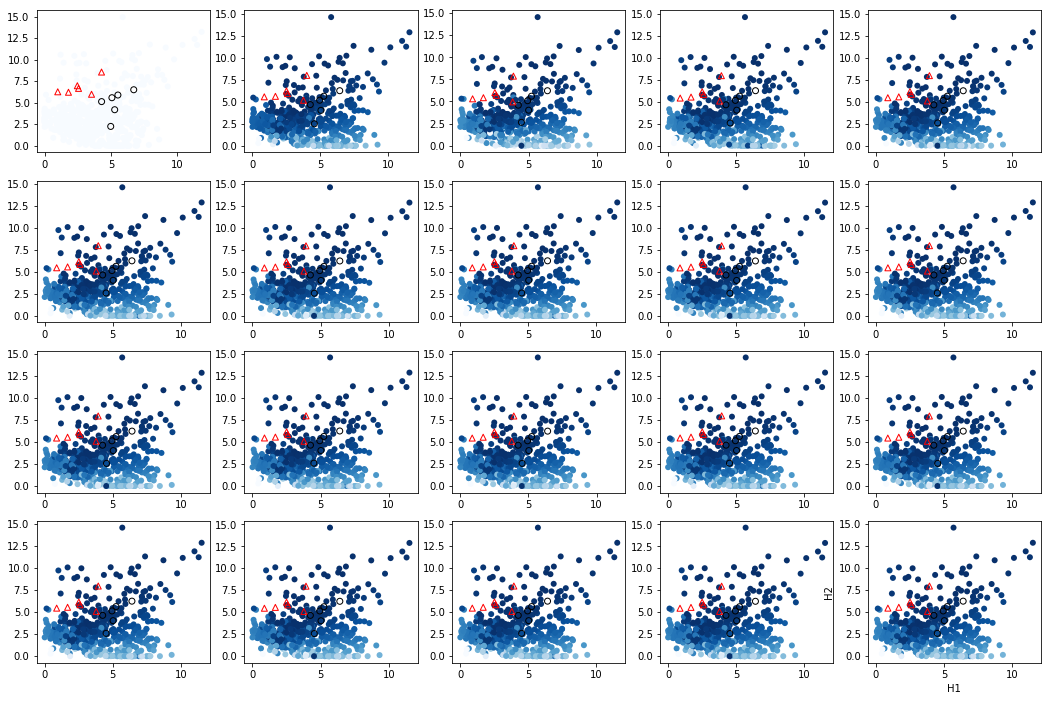

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))

choice = 'max'
for iteration in range(num_iterations):
    X = H[choice][iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_sim = weight_matrices[choice][iteration][:].mean(axis=1).mean(axis=1)
    axes[iteration/5][iteration%5].scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    axes[iteration/5][iteration%5].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/5][iteration%5].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

KeyError: 6

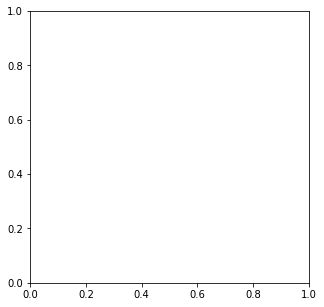

In [50]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 50))
fig, ax = plt.subplots(figsize=(5,5))
for iteration in [6]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    ax.scatter(X[(num_test+num_validate):, x1], X[(num_test+num_validate):, x2], c = train_sim, cmap='Blues', lw=0)
    ax.scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    ax.scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='red', marker='^', facecolors='none')
    plt.xlabel("H1")
    plt.ylabel("H2")
    ax.set_title("iteration {}". format(iteration))
    
#     plt.savefig("weight_iteration_6.pdf", format='pdf')
#     axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

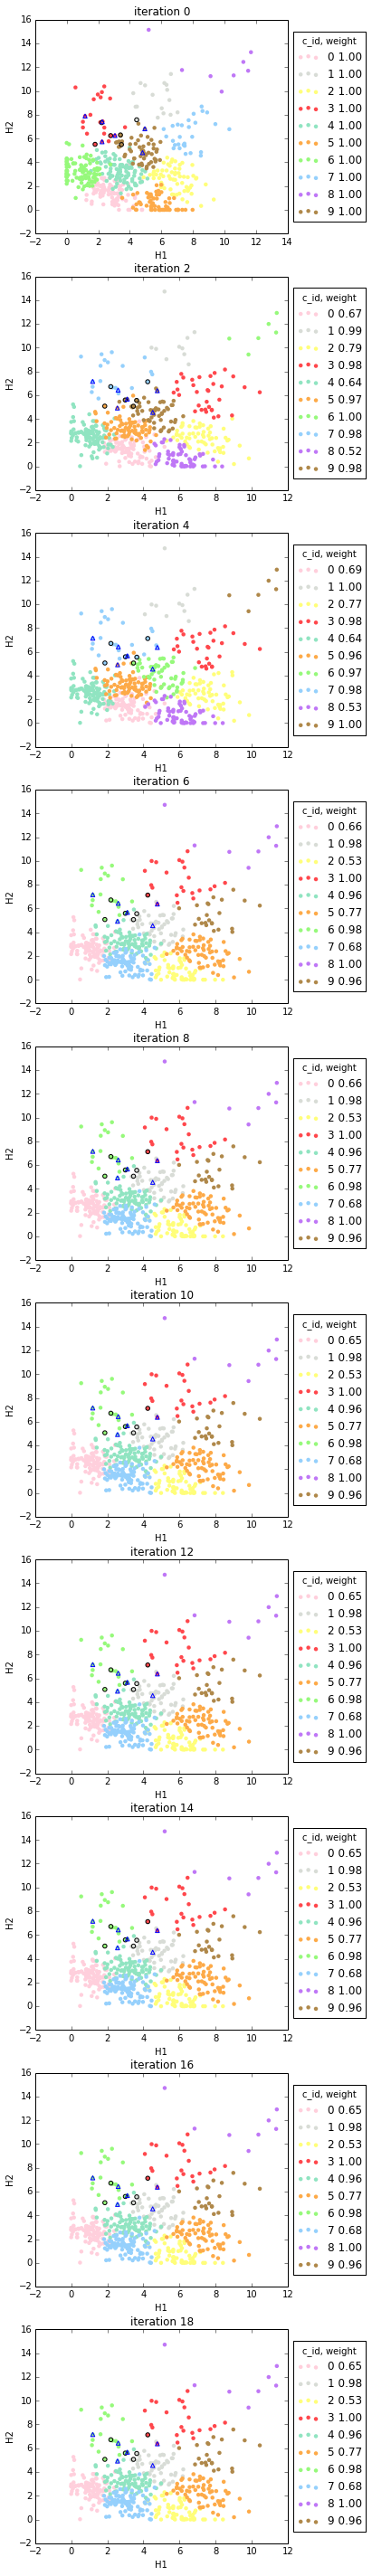

In [316]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(5, 50))

colors = ['#ffcfdc', '#d8dcd6', '#fffe7a', '#ff474c', '#90e4c1', '#fdaa48', '#96f97b', '#95d0fc', '#bf77f6', '#af884a']
for iteration in range(0, num_iterations, 2):
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    x1, x2 = (-np.var(X, axis=0)).argsort()[:2]
    x1 = 2
    x2 = 0
    
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
    
    for c_id in set(cluster):
        
        sub_cluster = sim_df.loc[sim_df[0] == c_id]
        mean_sim = format(sub_cluster[1].mean(axis=0), '.2f')
        
        index = [i for i,j in enumerate(cluster) if j == c_id]
        axes[iteration/2].scatter(X[index, x1], X[index, x2], c = colors[c_id], lw=0, label="{} {}".format(c_id, mean_sim))
    axes[iteration/2].scatter(X[:num_test, x1], X[:num_test, x2], color='black', marker='o', facecolors='none')
    axes[iteration/2].scatter(X[num_test:(num_test+num_validate), x1], X[num_test:(num_test+num_validate), x2], color='blue', marker='^', facecolors='none')
    axes[iteration/2].set_xlabel("H1")
    axes[iteration/2].set_ylabel("H2")
    axes[iteration/2].set_title("iteration {}". format(iteration))
    axes[iteration/2].legend(loc="center left", bbox_to_anchor=(1, 0.5), title='c_id, weight')
#     plt.title('iteration {}'.format(iteration))
#     plt.title("home factors learnt from aggregate readings")

In [26]:
for iteration in [1]:
    X = H[iteration]
    cluster = KMeans(n_clusters=10, random_state=0).fit_predict(X)
    train_cluster = cluster[(num_test + num_validate):]
    train_sim = weight_matrices[iteration][:].mean(axis=1).mean(axis=1)
    sim_df = pd.DataFrame(np.c_[train_cluster, train_sim], index=train_ix)
#     print sim_df
    for i in set(cluster):
        print i
        sub_cluster = sim_df.loc[sim_df[0] == i]
#         print sub_cluster[1]
        print sub_cluster[1].mean(axis=0)
    

0
0.720437494274
1
0.0135169107494
2
0.85064710518
3
0.782826517102
4
0.586187154995
5
0.968014577588
6
0.824718495544
7
0.919507619139
8
0.529737241121
9
0.349787779521


### validation homes

In [70]:
out_v = {}
for choice in ['max', 'min']:
    out_v[choice] = {}
    for iteration in range(num_iterations):
        out_v[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred_validation[choice][iteration][appliance]).loc[validate_ix]
            if appliance=="hvac":
                out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out_v[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

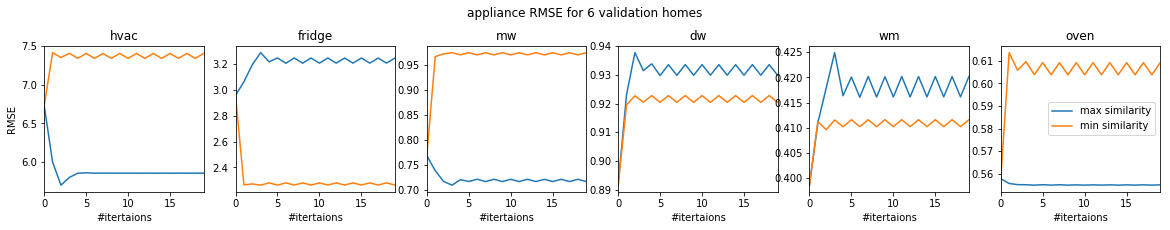

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out_v = {}
mean_out_v['min'] = pd.DataFrame(out_v['min'])
mean_out_v['max'] = pd.DataFrame(out_v['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out_v['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out_v['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 validation homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_validate.pdf", format='pdf')

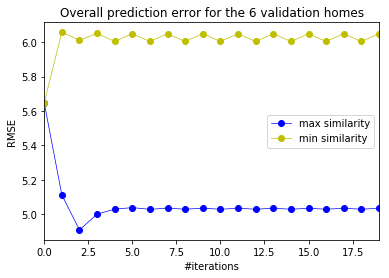

In [87]:
fig, ax = plt.subplots()
error_v = {}
error_v['max'] = (mean_out_v['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error_v['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error_v['min'] = (mean_out_v['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error_v['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 validation homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_validate.pdf", format='pdf')

### test homes

In [49]:
out = {}
for choice in ['max', 'min']:
    out[choice] = {}
    for iteration in range(num_iterations):
        out[choice][iteration] = {}
        for appliance in APPLIANCES_ORDER[1:]:
            s = pd.concat(pred[choice][iteration][appliance]).loc[test_ix]
            if appliance=="hvac":
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance,s[range(4, 10)], 'Austin')[2]
            else:   
                out[choice][iteration][appliance] = compute_rmse_fraction(appliance, s, 'Austin')[2]

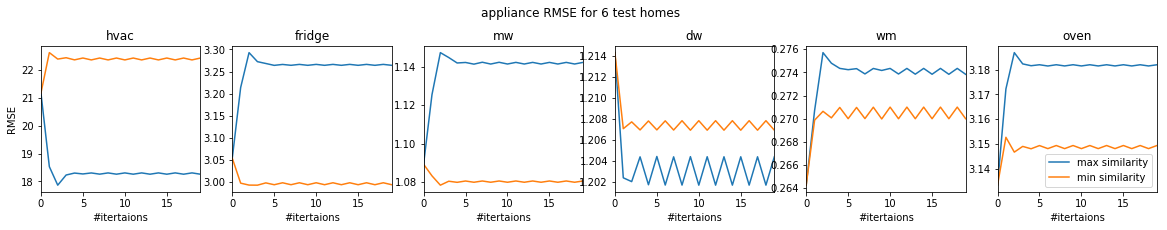

In [103]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20,3))
ax = axes.flatten()
count = 0
mean_out = {}
mean_out['min'] = pd.DataFrame(out['min'])
mean_out['max'] = pd.DataFrame(out['max'])

for appliance in APPLIANCES_ORDER[1:]:
    mean_out['max'].T[appliance].plot(ax = ax[count], title=appliance)
    mean_out['min'].T[appliance].plot(ax = ax[count], title=appliance)
    ax[count].set_xlabel("#itertaions")
    count += 1
ax[0].set_ylabel("RMSE")
ax[count-1].legend(['max similarity', 'min similarity'])
plt.suptitle("appliance RMSE for 6 test homes")
fig.subplots_adjust(top=0.8)
plt.savefig("appliance-RMSE_test.pdf", format='pdf')

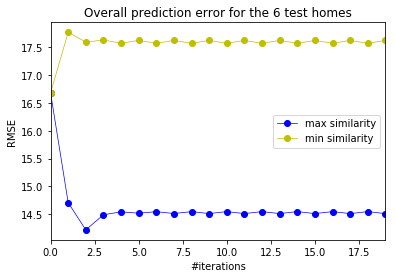

In [102]:
fig, ax = plt.subplots()
error['max'] = (mean_out['max'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['max'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
error['min'] = (mean_out['min'].T*pd.Series(contri['Austin'])).sum(axis=1)
error['min'].plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['y'])
ax.set_xlabel("#iterations")
ax.set_ylabel("RMSE")
ax.set_title("Overall prediction error for the 6 test homes")
ax.legend(['max similarity', 'min similarity'])
plt.savefig("overall-RMSE_test.pdf", format='pdf')

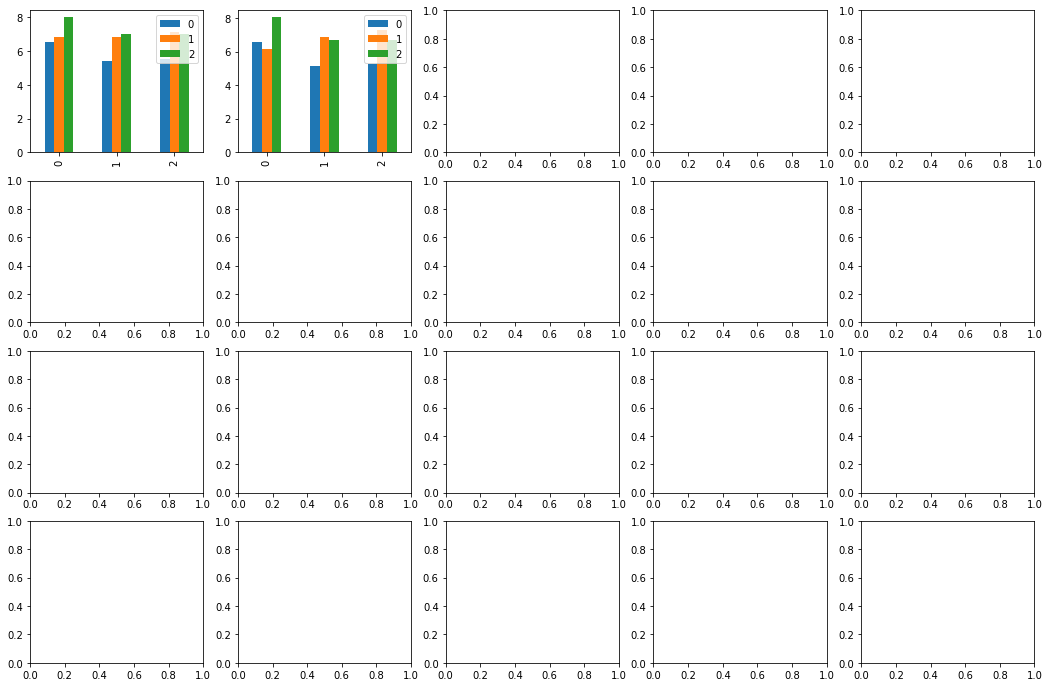

In [101]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18,12))


pd.DataFrame(A['max'][2][0]).plot(ax=axes[0][0], kind='bar')
pd.DataFrame(A['min'][2][0]).plot(ax=axes[0][1], kind='bar')
